In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets

Kod z perceptronu mam poniżej sekcji z EDA

# EDA z poprzedniego notatnika + pewne modyfikacje

In [4]:
X = X.drop(columns=['contact', 'duration', 'pdays'])
X.loc[X['previous'] != 0, 'previous'] = 1

In [ ]:
bins = [-float('inf'), -1, 249, 999, float('inf')]
labels = ['negative', '0-249', '250-999', 'over_1k']
X['balance_category'] = pd.cut(X['balance'], bins=bins, labels=labels)
X = X.drop(columns=['balance'])
print(X['balance_category'].value_counts())

balance_category
over_1k     14642
0-249       13658
250-999     13145
negative     3766
Name: count, dtype: int64


In [ ]:
bins = [-float('inf'), 1, 4, 9, float('inf')]
labels = ['1', '2-4', '5-9', '10_or_more']
X['campaign_category'] = pd.cut(X['campaign'], bins=bins, labels=labels)
X = X.drop(columns=['campaign'])
print(X['campaign_category'].value_counts())

campaign_category
2-4           21548
1             17544
5-9            4657
10_or_more     1462
Name: count, dtype: int64


In [ ]:
bins = [0, 30, 60, X['age'].max()]
labels = ['young', 'middle_aged', 'senior']
X['age_category'] = pd.cut(X['age'], bins=bins, labels=labels)
X = X.drop(columns=['age'])
print(X['age_category'].value_counts())

age_category
middle_aged    36993
young           7030
senior          1188
Name: count, dtype: int64


Fragmenty kodu podbrane od Wojdasa :)

In [ ]:
mask = (X['poutcome'].isna())
X.loc[mask, 'poutcome'] = 'none'

In [ ]:
# cyclic encoding dla month
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_to_num = {month: idx for idx, month in enumerate(months)}
X['month_num'] = X['month'].map(month_to_num)
X['month_sin'] = np.sin(2 * np.pi * X['month_num'] / 12)

X = X.drop(columns=['month', 'month_num'])

X['day_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 31)
X = X.drop(columns=['day_of_week'])

Podział zbioru na treningowy - walidacyjny - testowy w proporcji 0.8 - 0.2 - 0.2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # random state dla powtarzalności wyniku
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

Uzupełnianie `job` oraz `education` ich własnym rozkładem

In [ ]:
def get_column_distribution(df, column):
  return df[column].value_counts(normalize=True)

In [ ]:
def fill_nans(column):
  distribution = get_column_distribution(X_train, column)
  vals = distribution.index
  probs = distribution.values
  missing_in_train = X_train[column].isna()
  missing_in_val = X_val[column].isna()
  missing_in_test = X_test[column].isna()
  X_train.loc[missing_in_train, column] = np.random.choice(vals, size=missing_in_train.sum(), p=probs)
  X_val.loc[missing_in_val, column] = np.random.choice(vals, size=missing_in_val.sum(), p=probs)
  X_test.loc[missing_in_test, column] = np.random.choice(vals, size=missing_in_test.sum(), p=probs)

In [ ]:
fill_nans('job')
fill_nans('education')

Dla zmiennych `job`, `marital` oraz `poutcome` zastosuję one-hot-encoding, a dla pozostałych numerację 0, 1 itd.

In [ ]:
import numpy as np
import pandas as pd

one_hot_cols = ['job', 'marital', 'poutcome']
binary_map_cols = ['default', 'housing', 'loan']

for col in one_hot_cols: # one-hot encoding
  X_train = pd.get_dummies(data=X_train, prefix=col, columns=[col], dtype=np.int64)
  X_val = pd.get_dummies(data=X_val, prefix=col, columns=[col], dtype=np.int64)
  X_test = pd.get_dummies(data=X_test, prefix=col, columns=[col], dtype=np.int64)

for col in X_train.columns.copy():
  if col in binary_map_cols: # kodowanie dla zmiennych binarnych
    if col in X_train.columns and len(X_train[col].unique()) == 2:
      X_train[col] = X_train[col].map({'yes': 1, 'no': 0})
      X_val[col] = X_val[col].map({'yes': 1, 'no': 0})
      X_test[col] = X_test[col].map({'yes': 1, 'no': 0})
  else:
    # kodowanie pozostałych zmiennych
    if col == 'education':
      mapping = {'primary': 0, 'secondary': 1, 'tertiary': 2}
    elif col == 'age_category':
      mapping = {
          'young': 0,
          'middle_aged': 1,
          'senior': 2
      }
    elif col == 'balance_category':
      mapping = {
          'negative': 0,
          '0-249': 1,
          '250-999': 2,
          'over_1k': 3
      }
    elif col == 'campaign_category':
      mapping = {
          '1': 0,
          '2-4': 1,
          '5-9': 2,
          '10_or_more': 3
      }
    else:
      continue # uniknięcie zakodowania jednej z już zakodowanych wcześniej kolumn
    X_train[col] = X_train[col].astype(str).map(mapping)
    X_val[col] = X_val[col].astype(str).map(mapping)
    X_test[col] = X_test[col].astype(str).map(mapping)


Zakodowanie zmiennej decyzyjnej.

In [ ]:
y_train = y_train['y'].map({'yes': 1, 'no': 0})
y_test = y_test['y'].map({'yes': 1, 'no': 0})
y_val = y_val['y'].map({'yes': 1, 'no': 0})

Skalowanie danych

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Sieci
Implementacja perceptrona. Spośród dwóch podanych funkcji aktywacji wybrałem sigmoid. Uznałem ją za lepszą do problemu klasyfikacji, jako że przyjmuje wartość w zakresie od 0 do 1. Dodatkowo, zwykle jest stosowana w ostatniej warstwie złożonych sieci a tutaj sieć składać się będzie tylko z jednej warstwy. Relu natomiast może zwrócić dowolną liczbę nieujemną zerując przy tym liczby ujemne, co uważam za nieodpowiednie w przypadku gdy dane są ustandaryzowane.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

In [ ]:
class Perceptron:

  def __init__(self, k: int):
    self.w = np.random.rand(1,k) - 0.5 # losowe wagi w przedziale -0.5 do 0.5
    self.b = np.random.rand() - 0.5 # tak samo ze skalarem b

  def forward(self, X: np.ndarray): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    Z = np.add(np.matmul(X, self.w.T), self.b)
    A = np.divide(1, np.add(1, np.exp(-Z))) # sigmoid
    return A

Implementacja klasy do trenowania. Jako funkcję straty wybrałem BCE, które w połączeniu z sigmoidem zwróci łatwą pochodną co przedstawię za chwilkę. Tutaj wzór BCE gdzie A to predykcje modelu a Gt to rzeczywiste wartości.
$$
L(A, Gt) =
-\frac{1}{N} \sum_{i=1}^{N}
\left[
Gt_i \log(A_i)
+ (1 - Gt_i)\log(1 - A_i)
\right]
$$

Teraz czas na pochodną, która jest potrzebna do aktualizacji parametrów modelu. Dla wag będzie wyglądać w następujący sposób, co zostało już pokazane w notatniku z treścią zadania.

$$\frac{∂L}{∂𝑤} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂w}$$

Dla skalara b wzór ten przyjmie postać:

$$\frac{∂L}{∂b} = \frac{∂L}{∂A} \frac{∂A}{∂Z} \frac{∂Z}{∂b}$$

W obu przypadakch trzeba najpierw wyznaczyć $\frac{∂L}{∂A}$ oraz $\frac{∂A}{∂Z}$. Wynoszą one kolejno:
$$\frac{∂L}{∂A} = \frac{-y}{A} + \frac{1-y}{1-A} = \frac{A-y}{A(1-A)}$$

$$\frac{∂A}{∂Z} = \frac{e^{-z}}{(1 + e^{-z})^2} $$

Jako że $A= \frac{1}{1 + e^{-z}} $ oraz $e^{-z} = \frac{1}{A}-1$ to:
$$\frac{∂A}{∂Z} = A^2(\frac{1}{A}-1) = A(1-A) $$
czyli:
$$\frac{∂L}{∂A} \frac{∂A}{∂Z} = \frac{A-y}{A(1-A)} A(1-A) = A-y$$

W kolejnym kroku $\frac{∂Z}{∂w}$ wynosi $X$ a $\frac{∂Z}{∂b}$ wynosi 1.

In [ ]:
class Trainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int, alpha):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.alpha = alpha
    # parametry implementowanego optimizera
    self.m_w = np.zeros_like(self.perceptron.w)
    self.v_w = np.zeros_like(self.perceptron.w)
    self.m_b = 0.0
    self.v_b = 0.0
    self.t = 0

  def loss(self, A: np.array, y: np.ndarray): # oblicza stratę między wyjściem sieci a ground truth
    A = np.clip(A, 1e-8, 1 - 1e-8) # w przypadku wystąpienia dokładnie 0 lub 1 w predykcji zamieniane są one na kolejno 10^(-8) oraz 1 - 10^(-8)
    return -np.mean(y*np.log(A) + (1-y)*np.log(1-A)) # strata BCE

  def backward(self, A: np.array, y: np.ndarray, X): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    y_reshaped = y.reshape(-1, 1) if y.ndim == 1 else y
    # wyznaczanie gradientów dla sigmoid + BCE loss
    dZ = A - y_reshaped
    dW = np.mean(X * dZ, axis=0, keepdims=True)
    dB = np.mean(dZ)
    return dW, dB

  def update_weights(self, d): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    return self.alpha * d

  def train(self, X: np.ndarray, y: np.ndarray, batch_size=1, train=True, optimizer=False, beta1=0.9, beta2=0.999): # wykonuje trenowanie w N epokach
    loss_sum = 0
    for start_idx in range(0, X.shape[0], batch_size):
      end_idx = min(start_idx + batch_size, X.shape[0])
      X_batch = X[start_idx:end_idx]
      y_batch = y[start_idx:end_idx]
      A = self.perceptron.forward(X_batch) # wektor wyjściowy perceptronu
      loss = self.loss(A, y_batch) # obliczanie straty
      if train:
        dW, dB = self.backward(A, y_batch, X_batch)
        if optimizer: # implementacja optimizera adam
          self.t += 1
          self.m_w = beta1 * self.m_w + (1 - beta1) * dW
          self.v_w = beta2 * self.v_w + (1 - beta2) * (dW ** 2)
          dW = (self.m_w / (1 - beta1 ** self.t)) / (np.sqrt(self.v_w / (1 - beta2 ** self.t)) + 1e-8)

          self.m_b = beta1 * self.m_b + (1 - beta1) * dB
          self.v_b = beta2 * self.v_b + (1 - beta2) * (dB ** 2)
          dB = (self.m_b / (1 - beta1 ** self.t)) / (np.sqrt(self.v_b / (1 - beta2 ** self.t)) + 1e-8)
        # aktualizacja wag
        self.perceptron.w -= self.update_weights(dW)
        self.perceptron.b -= self.update_weights(dB)
      loss_sum += abs(loss)
    return loss_sum / X.shape[0]

  def get_metrics(self, X: np.ndarray, y: np.ndarray):
    predictions = self.predict(X)
    tp = np.sum((predictions == 1) & (y == 1))
    fp = np.sum((predictions == 1) & (y == 0))
    fn = np.sum((predictions == 0) & (y == 1))
    accuracy = np.mean(predictions == y)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return accuracy, precision, recall

  def predict(self, X: np.ndarray) -> np.ndarray: # funkcja na wykonanie inferencji
    probabilities = self.perceptron.forward(X)
    return (probabilities >= 0.5).astype(int)

Klasa do trenowania utworzona do teraz czas na eksperymenty. Poniżej napisałem funkcję do testów, która zbiera wyniki dla zbiorów treningowego oraz walidacyjnego włącznie z wybranymi metrykami. Dla każdej wartości alpha ustawiłem inną liczbę epok a w samej funkcji można ustawić wielkość batch'a oraz optimizer Adam.

In [ ]:
def experiment_func(batch=1, optimizer=False):
  plt.figure(figsize=(15, 15))
  for idx, (alpha_val, epochs_val) in enumerate(zip([0.01, 0.001, 0.0001], [5, 15, 30])):
    p = Perceptron(X_train.shape[1])
    t = Trainer(p, epochs_val, alpha_val)

    training_losses = []
    validation_losses = []
    train_accuracy = []
    train_precision = []
    train_recall = []
    val_accuracy = []
    val_precision = []
    val_recall = []
    print("Alpha: ", alpha_val)
    for i in range(t.n_epochs):
      training_losses.append(t.train(X_train.values, y_train.values, batch_size=batch, optimizer=optimizer))
      validation_losses.append(t.train(X_val.values, y_val.values, batch_size=batch, optimizer=optimizer, train=False))
      # zebranie metryk dla zbioru treningowego
      acc, prec, rec = t.get_metrics(X_train.values, y_train.values)
      train_accuracy.append(acc)
      train_precision.append(prec)
      train_recall.append(rec)
      # zebranie metryk dla zbioru walidacyjnego
      acc, prec, rec = t.get_metrics(X_val.values, y_val.values)
      val_accuracy.append(acc)
      val_precision.append(prec)
      val_recall.append(rec)
      if i % 5 == 4 or i<4:
        print("epoch: ", i+1, f" - training loss: {training_losses[-1]:.6f} - validation loss: {validation_losses[-1]:.6f}")
    # wykresy BCE loss
    plt.subplot(3, 3, idx+1)
    plt.title(f"alpha = {alpha_val}")
    plt.grid()
    plt.plot(training_losses, label="Trening")
    plt.plot(validation_losses, label="Walidacja")
    plt.legend()
    # wykresy metryk na zbiorze treningowym
    plt.subplot(3, 3, idx+4)
    plt.title(f"alpha = {alpha_val}")
    plt.grid()
    plt.plot(train_accuracy, label="train accuracy")
    plt.plot(train_precision, label="train precision")
    plt.plot(train_recall, label="train recall")
    plt.legend()
    # wykresy metryk na zbiorze walidacyjnym
    plt.subplot(3, 3, idx+7)
    plt.title(f"alpha = {alpha_val}")
    plt.grid()
    plt.plot(val_accuracy, label="val accuracy")
    plt.plot(val_precision, label="val precision")
    plt.plot(val_recall, label="val recall")
    plt.legend()
  plt.show()

Trening bez stosowania batch'y (batch=1 oznacza trening na pojedynczych próbkach)

Alpha:  0.01
epoch:  1  - training loss: 0.324099 - validation loss: 0.322092
epoch:  2  - training loss: 0.317044 - validation loss: 0.321779
epoch:  3  - training loss: 0.316952 - validation loss: 0.321744
epoch:  4  - training loss: 0.316944 - validation loss: 0.321726
epoch:  5  - training loss: 0.316941 - validation loss: 0.321716
Alpha:  0.001
epoch:  1  - training loss: 0.356450 - validation loss: 0.342117
epoch:  2  - training loss: 0.327279 - validation loss: 0.331006
epoch:  3  - training loss: 0.321174 - validation loss: 0.326462
epoch:  4  - training loss: 0.318261 - validation loss: 0.324038
epoch:  5  - training loss: 0.316604 - validation loss: 0.322624
epoch:  10  - training loss: 0.314063 - validation loss: 0.320472
epoch:  15  - training loss: 0.313697 - validation loss: 0.320188
Alpha:  0.0001
epoch:  1  - training loss: 0.426469 - validation loss: 0.402672
epoch:  2  - training loss: 0.377945 - validation loss: 0.384364
epoch:  3  - training loss: 0.363440 - validat

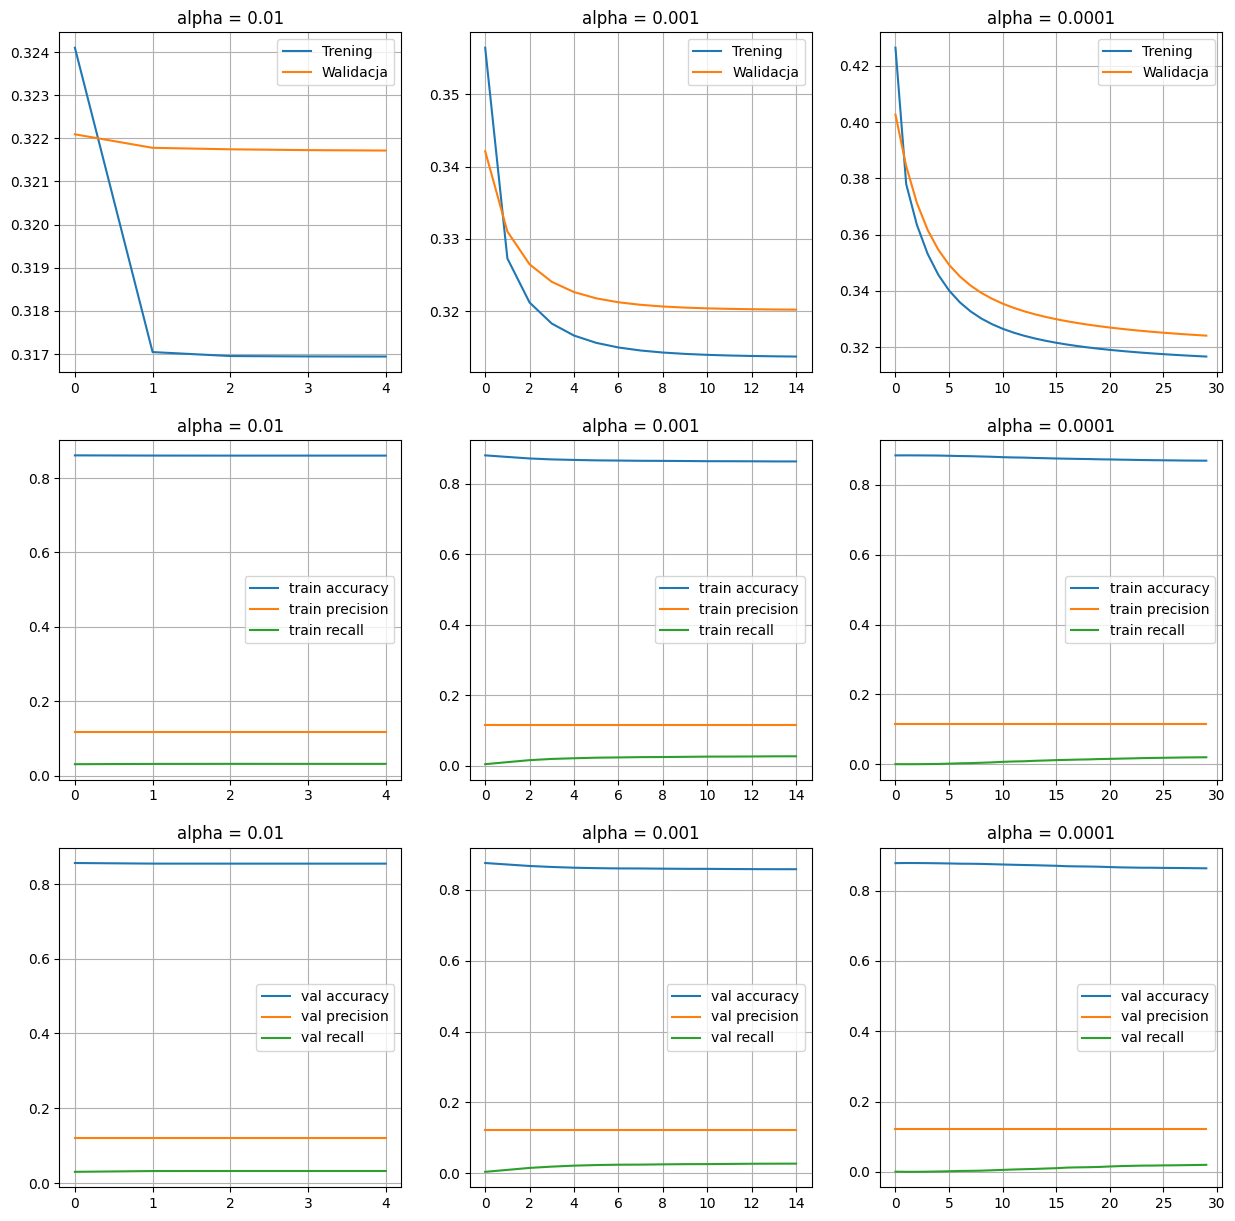

In [ ]:
experiment_func(batch=1)

Trening z zastosowaniem batch'y o rozmmiarze 32.

Alpha:  0.01
epoch:  1  - training loss: 0.012542 - validation loss: 0.012353
epoch:  2  - training loss: 0.011901 - validation loss: 0.012257
epoch:  3  - training loss: 0.011895 - validation loss: 0.012309
epoch:  4  - training loss: 0.011955 - validation loss: 0.012377
epoch:  5  - training loss: 0.012016 - validation loss: 0.012434
Alpha:  0.001
epoch:  1  - training loss: 0.019263 - validation loss: 0.013549
epoch:  2  - training loss: 0.012488 - validation loss: 0.012395
epoch:  3  - training loss: 0.011945 - validation loss: 0.012229
epoch:  4  - training loss: 0.011834 - validation loss: 0.012185
epoch:  5  - training loss: 0.011795 - validation loss: 0.012164
epoch:  10  - training loss: 0.011745 - validation loss: 0.012129
epoch:  15  - training loss: 0.011760 - validation loss: 0.012148
Alpha:  0.0001
epoch:  1  - training loss: 0.014285 - validation loss: 0.014400
epoch:  2  - training loss: 0.013932 - validation loss: 0.014098
epoch:  3  - training loss: 0.013652 - validat

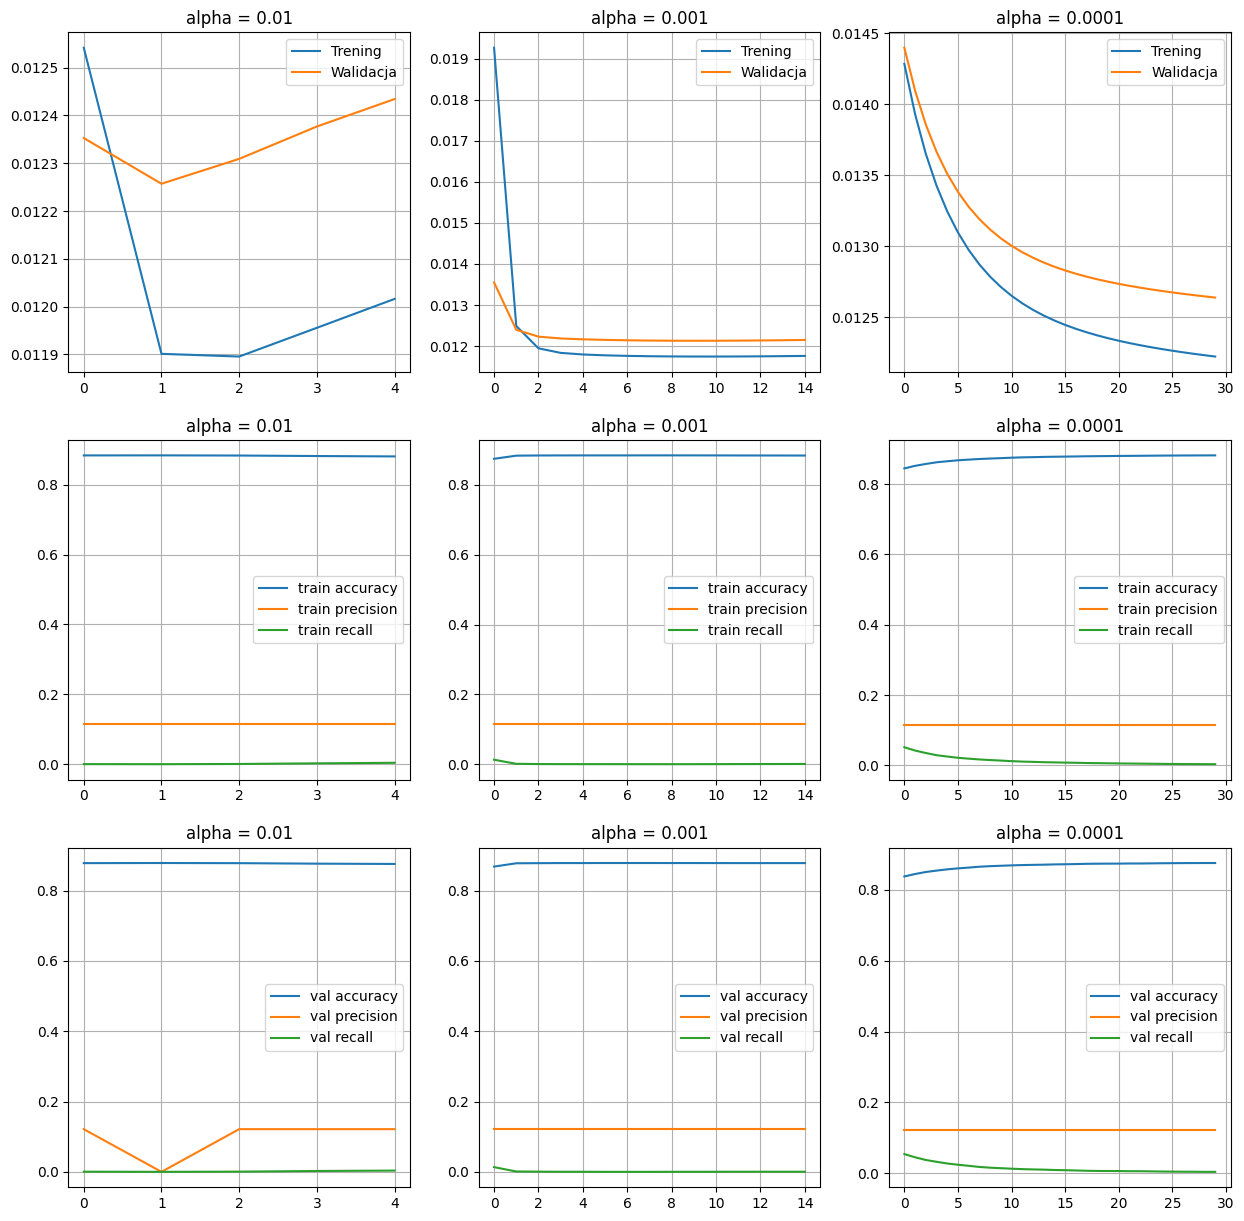

In [ ]:
experiment_func(batch=32)

Trening z zastosowaniem batch'y o rozmmiarze 32 oraz optimizera Adam.

Alpha:  0.01
epoch:  1  - training loss: 0.012980 - validation loss: 0.012983
epoch:  2  - training loss: 0.012548 - validation loss: 0.012978
epoch:  3  - training loss: 0.012543 - validation loss: 0.012980
epoch:  4  - training loss: 0.012543 - validation loss: 0.012981
epoch:  5  - training loss: 0.012544 - validation loss: 0.012982
Alpha:  0.001
epoch:  1  - training loss: 0.012136 - validation loss: 0.012238
epoch:  2  - training loss: 0.011874 - validation loss: 0.012305
epoch:  3  - training loss: 0.012000 - validation loss: 0.012457
epoch:  4  - training loss: 0.012143 - validation loss: 0.012588
epoch:  5  - training loss: 0.012255 - validation loss: 0.012684
epoch:  10  - training loss: 0.012458 - validation loss: 0.012848
epoch:  15  - training loss: 0.012482 - validation loss: 0.012868
Alpha:  0.0001
epoch:  1  - training loss: 0.038014 - validation loss: 0.031251
epoch:  2  - training loss: 0.026257 - validation loss: 0.022084
epoch:  3  - training loss: 0.019128 - validat

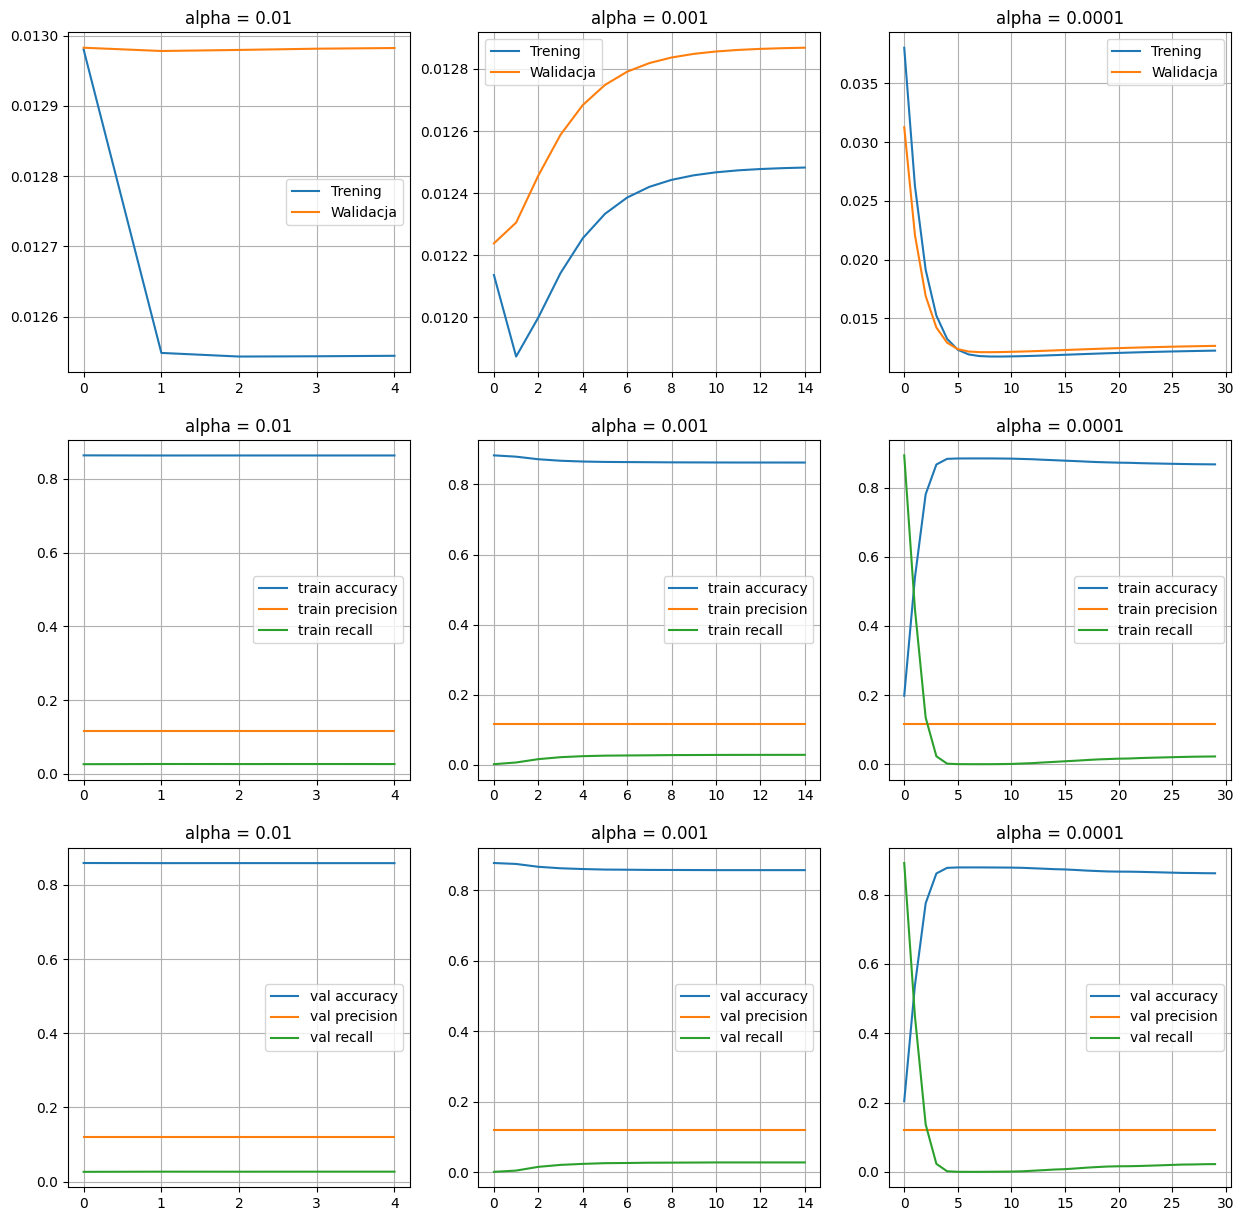

In [ ]:
experiment_func(batch=32, optimizer=True)

Powyższe eksperymenty wskazują na pozytywny wpływ zastosowania batchy (znacznie mniejsza strata dla rozmiaru 32 w porównaniu z pojedynczymi próbkami). Dodatkowo optimizer okazuje się szczególnie pomocny przy niższym współczynniku uczenia. Wtedy optimizer pozwala na szybkie kroki w obszarze małego gradientu oraz na ostrożniejsze kroki przy dużym gradiencie. Jeżeli współczynnik uczenia jest zbyt duży, wtedy optimizer nie jest w stanie zachować ostrożności przy wyższym gradiencie. W przypadku wykresów straty BCE wykazuje minimalnie gorsze wyniki niż podczas testów bez optimziera, jednak po metrykach zauważyć można, że powiązane jest to z częstszą predykcją klasy 1 (wzrost recall)

# Sieć pytorch 🔥🔥🔥

Implementacja perceptrona z kodu wyżej na kod wykorzystujący torch.nn

In [ ]:
class TorchPerceptron(nn.Module):

  def __init__(self, k: int):
    super().__init__()
    self.w = nn.Parameter(torch.rand(1, k) - 0.5)
    self.b = nn.Parameter(torch.rand(1) - 0.5)

  def forward(self, X: torch.Tensor): # dołóż więcej argumentów wejściowych, jeśli są potrzebne
    Z = torch.matmul(X, self.w.T) + self.b
    A = torch.sigmoid(Z)
    return A

Klasa do treningu przepisana na torch.nn. Dodatkowo, zastosowano cuda w celu szybszego treningu.

In [ ]:
class TorchTrainer:

  def __init__(self, perceptron: Perceptron, n_epochs: int, alpha, loss, optim):
    self.perceptron = perceptron
    self.n_epochs = n_epochs
    self.alpha = alpha
    self.loss_func = loss
    self.optim = optim

  def torchtrain(self, X: torch.Tensor, y: torch.Tensor, bs=1, train=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.perceptron.to(device)
    X = X.to(device)
    y = y.to(device)
    # trening
    if train:
      self.perceptron.train()
      for i in range((X.shape[0] - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = X[start_i:end_i]
        yb = y[start_i:end_i]
        yb = yb.unsqueeze(1)
        self.optim.zero_grad()
        pred = self.perceptron(xb)
        loss = self.loss_func(pred, yb)

        loss.backward()
        self.optim.step()
    # walidacja
    self.perceptron.eval()
    with torch.no_grad():
      valid_loss = 0.0
      for i in range((X.shape[0] - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = X[start_i:end_i]
        yb = y[start_i:end_i]
        yb = yb.unsqueeze(1)
        valid_loss += self.loss_func(self.perceptron(xb), yb).item()
    return valid_loss / X.shape[0]

  def get_metrics(self, X: torch.Tensor, y: torch.Tensor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = X.to(device)
    y = y.to(device)
    self.perceptron.eval()
    with torch.no_grad():
        predictions = self.predict(X)
        tp = torch.sum((predictions == 1) & (y == 1))
        fp = torch.sum((predictions == 1) & (y == 0))
        fn = torch.sum((predictions == 0) & (y == 1))
        accuracy = torch.mean((predictions == y).float())
        precision = tp / (tp + fp) if (tp + fp) > 0 else torch.tensor(0.0).to(device)
        recall = tp / (tp + fn) if (tp + fn) > 0 else torch.tensor(0.0).to(device)
    return accuracy.item(), precision.item(), recall.item()

  def predict(self, X: torch.Tensor) -> torch.Tensor: # funkcja na wykonanie inferencji
    probabilities = self.perceptron(X)
    return (probabilities >= 0.5).float()

Funkcja do eksperymentów przepisana na pytorch.

In [ ]:
def torch_experiment_func(batch=1):
  plt.figure(figsize=(15, 15))
  for idx, (alpha_val, epochs_val) in enumerate(zip([0.01, 0.001, 0.0001], [5, 15, 30])):
    model = TorchPerceptron(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=alpha_val)
    loss_fn = nn.BCELoss()
    t = TorchTrainer(model, epochs_val, alpha_val, loss_fn, optimizer)

    training_losses = []
    validation_losses = []
    train_accuracy = []
    train_precision = []
    train_recall = []
    val_accuracy = []
    val_precision = []
    val_recall = []
    print("Alpha: ", alpha_val)
    for i in range(t.n_epochs):
      torch_X_train = torch.tensor(X_train.values).float()
      torch_y_train = torch.tensor(y_train.values).float()
      torch_X_val = torch.tensor(X_val.values).float()
      torch_y_val = torch.tensor(y_val.values).float()

      training_losses.append(t.torchtrain(torch_X_train, torch_y_train, bs=batch))
      validation_losses.append(t.torchtrain(torch_X_val, torch_y_val, bs=batch, train=False))
      # zebranie metryk dla zbioru treningowego
      acc, prec, rec = t.get_metrics(torch_X_train, torch_y_train)
      train_accuracy.append(acc)
      train_precision.append(prec)
      train_recall.append(rec)
      # zebranie metryk dla zbioru walidacyjnego
      acc, prec, rec = t.get_metrics(torch_X_val, torch_y_val)
      val_accuracy.append(acc)
      val_precision.append(prec)
      val_recall.append(rec)
      if i % 5 == 4 or i<4:
        print("epoch: ", i+1, f" - training loss: {training_losses[-1]:.6f} - validation loss: {validation_losses[-1]:.6f}")
    # wykresy BCE loss
    plt.subplot(3, 3, idx+1)
    plt.title(f"alpha = {alpha_val}")
    plt.grid()
    plt.plot(training_losses, label="Trening")
    plt.plot(validation_losses, label="Walidacja")
    plt.legend()
    # wykresy metryk na zbiorze treningowym
    plt.subplot(3, 3, idx+4)
    plt.title(f"alpha = {alpha_val}")
    plt.grid()
    plt.plot(train_accuracy, label="train accuracy")
    plt.plot(train_precision, label="train precision")
    plt.plot(train_recall, label="train recall")
    plt.legend()
    # wykresy metryk na zbiorze walidacyjnym
    plt.subplot(3, 3, idx+7)
    plt.title(f"alpha = {alpha_val}")
    plt.grid()
    plt.plot(val_accuracy, label="val accuracy")
    plt.plot(val_precision, label="val precision")
    plt.plot(val_recall, label="val recall")
    plt.legend()
  plt.show()

Trening bez stosowania batch'y

Alpha:  0.01
epoch:  1  - training loss: 0.328141 - validation loss: 0.331367
epoch:  2  - training loss: 0.328140 - validation loss: 0.331349
epoch:  3  - training loss: 0.328138 - validation loss: 0.331337
epoch:  4  - training loss: 0.328137 - validation loss: 0.331327
epoch:  5  - training loss: 0.328137 - validation loss: 0.331318
Alpha:  0.001
epoch:  1  - training loss: 0.313834 - validation loss: 0.320670
epoch:  2  - training loss: 0.313552 - validation loss: 0.320330
epoch:  3  - training loss: 0.313537 - validation loss: 0.320215
epoch:  4  - training loss: 0.313540 - validation loss: 0.320149
epoch:  5  - training loss: 0.313543 - validation loss: 0.320110
epoch:  10  - training loss: 0.313546 - validation loss: 0.320053
epoch:  15  - training loss: 0.313544 - validation loss: 0.320039
Alpha:  0.0001
epoch:  1  - training loss: 0.352784 - validation loss: 0.365521
epoch:  2  - training loss: 0.331158 - validation loss: 0.341634
epoch:  3  - training loss: 0.323023 - validat

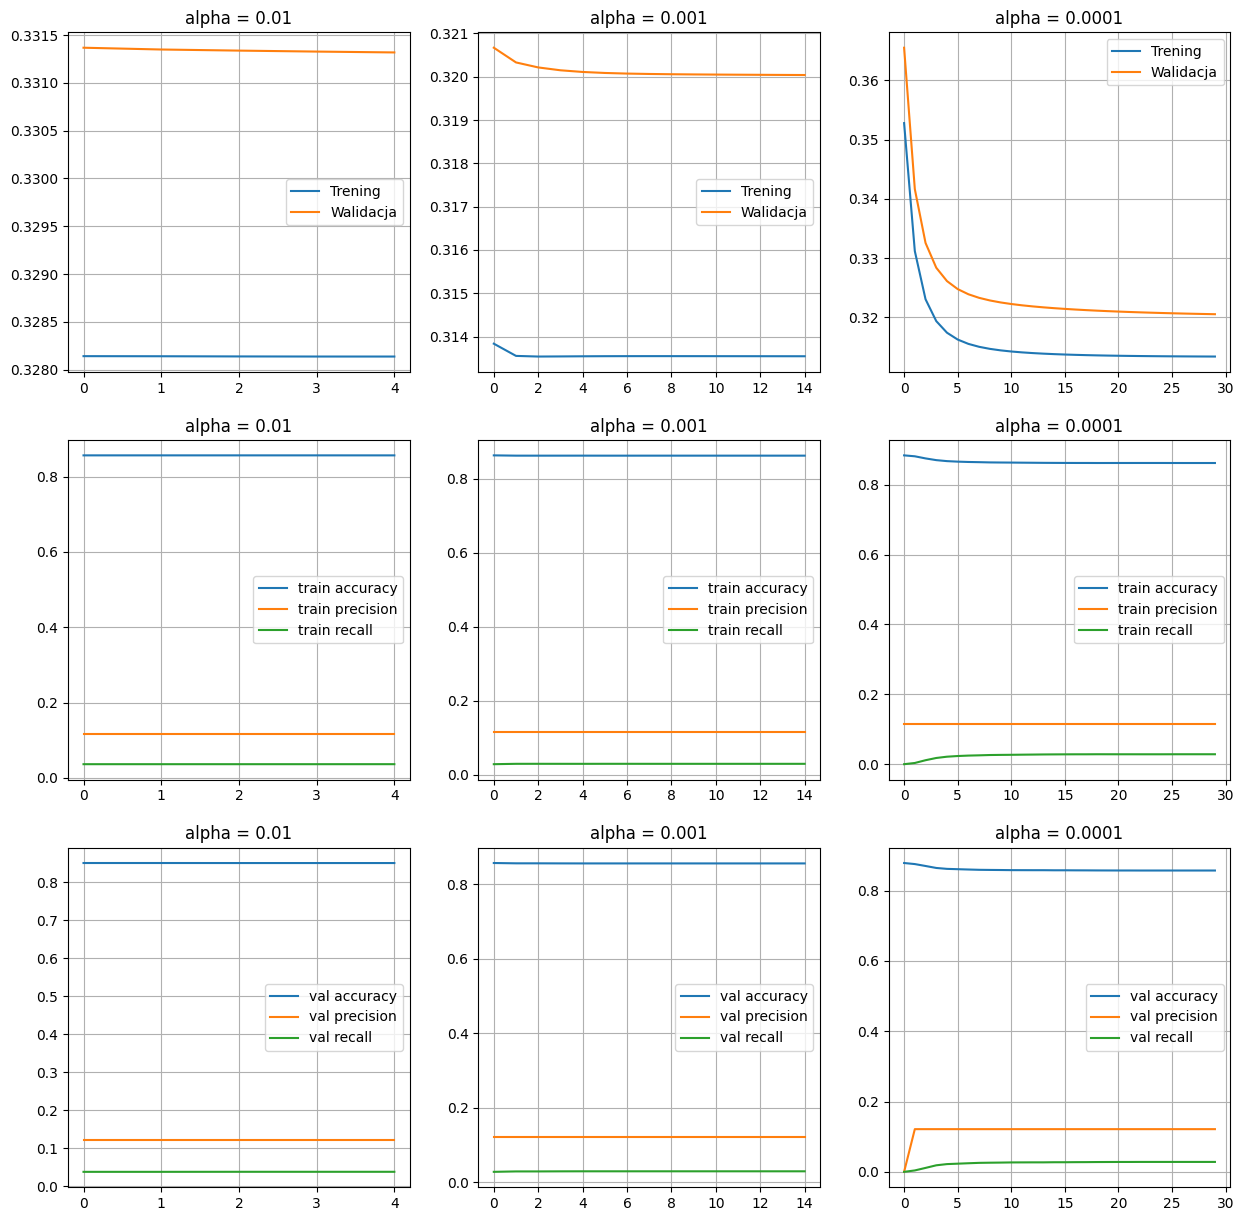

In [ ]:
torch_experiment_func(batch=1)

Trening z batch'em o roziarze 32.

Alpha:  0.01
epoch:  1  - training loss: 0.009817 - validation loss: 0.010085
epoch:  2  - training loss: 0.009820 - validation loss: 0.010077
epoch:  3  - training loss: 0.009826 - validation loss: 0.010077
epoch:  4  - training loss: 0.009829 - validation loss: 0.010076
epoch:  5  - training loss: 0.009830 - validation loss: 0.010076
Alpha:  0.001
epoch:  1  - training loss: 0.011054 - validation loss: 0.011462
epoch:  2  - training loss: 0.010260 - validation loss: 0.010589
epoch:  3  - training loss: 0.009977 - validation loss: 0.010260
epoch:  4  - training loss: 0.009872 - validation loss: 0.010132
epoch:  5  - training loss: 0.009830 - validation loss: 0.010078
epoch:  10  - training loss: 0.009796 - validation loss: 0.010030
epoch:  15  - training loss: 0.009794 - validation loss: 0.010024
Alpha:  0.0001
epoch:  1  - training loss: 0.026225 - validation loss: 0.026386
epoch:  2  - training loss: 0.018953 - validation loss: 0.019197
epoch:  3  - training loss: 0.015017 - validat

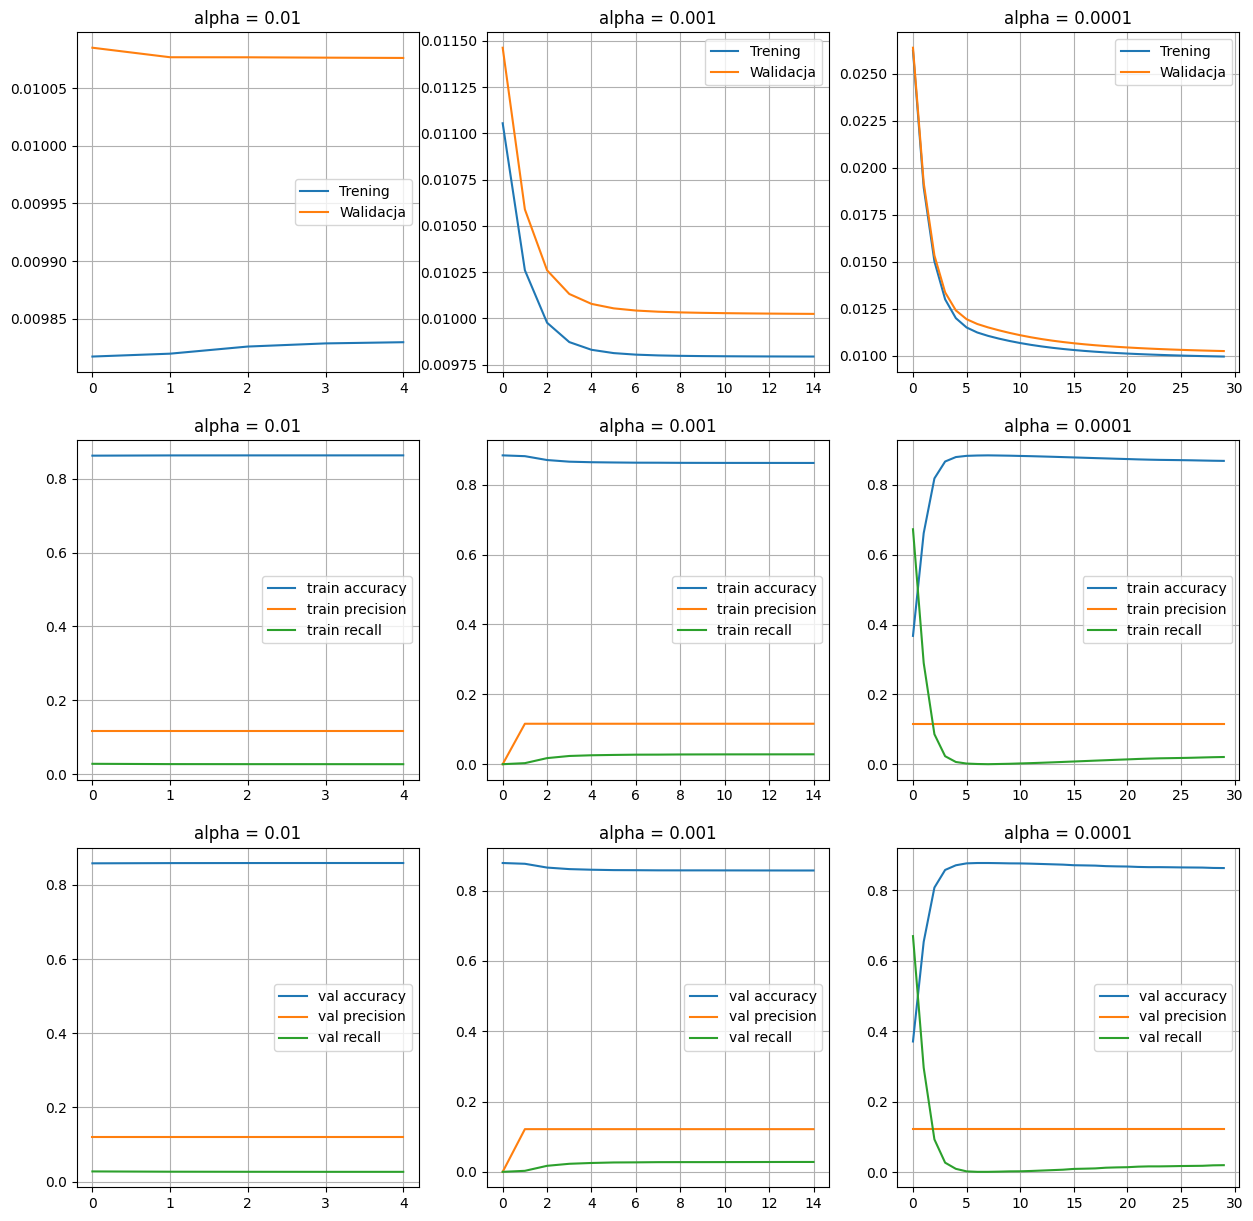

In [ ]:
torch_experiment_func(batch=32)

Przy braku stosowania batch'y sieć w torch.nn wykazuje podobną skuteczność co perceptron i w podobnie powolny sposób się uczy. Przy stosowaniu batch'y oraz optimizera sieć w torch.nn wykazuje nieco lepsze wyniki (mniejsza strata BCE) oraz sam trening był zdecydowanie szybszy dzięki zastosowaniu cuda. Metryki natomiast zachowują podobne wartości, co wskazuje na większą pewność predykcji modelu przy ich faktycznie niezmiennej jakości.